<a href="https://colab.research.google.com/github/maryamraozy/TSI/blob/master/Copy_of_Adams_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a copy of this file before editing

# Data Setup

**Export Data from Google Analytics**
- In Google Analytics, navigate to the *Behaviour* tab, *Site Content* and then *All Pages*
- On the table, add "Previous Page Path* as a Secondary Dimension. The table should now have *Page* and *Previous Page Path* as dimensions.
- Filter the table to the pages relevant to your services.
- At the top of the page, click on *Export*> *Unsample report* & tick the `Metadata` box.
- If the *Unsample report* option is not available due to restricted access, click on *Export*> *CSV*. For this option, ensure that you show the maximum number of rows: **5000**!


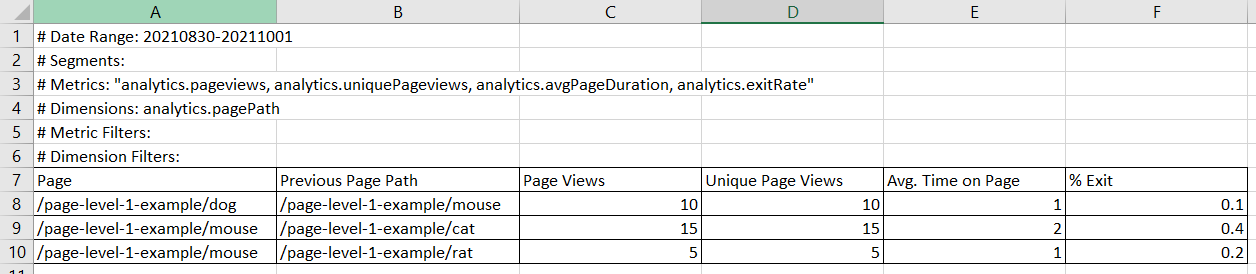

**Upload Data to Google Colab**
- Click on the *Files* icon on the left menu of Google Colab (i.e. of this document)
- If you are in the root directory (i.e. you can see folders like `bin` or `boot`) then navigate to the `content` folder
- Click on the *Upload to session storage* icon and select the Google Analytics csv extract from your File Explorer

**Update file name in script**
- Update the `filename` variable, so that it is the same as the name of the csv that was just uploaded

In [ ]:
filename = "/content/MA journey data (ASAD) - sqllab_untitled_query_2_20231016T124327 (2).csv"
service_name = 'MA (from ASAD)'

**Check and/or update the values below to change the figure configuration**

In [ ]:
# Data processing config
anonymised_digits = True
page_level_1_filter = None
page_level_2_filter = None
page_level_3_filter = None
# Add words into this list that can be used to match urls to remove
# Equivalent to dropping rows " where row like '%word%' " in sql/asad
remove_words = ['delete-answers']
# Visualisation format
font_size = 10
arrow_width_column = "Unique Page Views" # Options: ["Page Views",  "Unique Page Views"]
arrow_color_column = "% Exit" # Options: ["Avg. Time on Page", "% Exit"]
graph_precision = 90 # Percentage between  and 100. e.g. 80 keeps the top 80% journeys.

**Now run the script!**
- On the *Runtime* tab, click on *Run all*

**Script Output**
- The script exports an html file in the session storage menu. Click on *Files* on the left navigation menu to find the file. You might need to click the refresh button. Right click on the file to download it.
- If you are in the root directory, you will need to navigate the the content folder.
- You can now open the file in any browser to view the interactive visualisation.

# Script

In [ ]:
# Functions

def filter_for_word(df, col, word):
  filter = df[col].str.contains(word)
  return df[~filter]


### Import the packages




In [ ]:
%%capture
# !pip install networkx
# !pip install pyvis==0.3.1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyvis.network import Network
import networkx as nx
import datetime
import re

In [ ]:
# display large pandas dataframes as an interactive data table.
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


### Load dataframe

In [ ]:
df = pd.read_csv(filename)
df.head()

,Previous Page Path,Page,Page Views,Unique Page Views
0,(entrance),/pay-what-you-owe-in-instalments/arrangement/d...,15367,13539
1,(entrance),/pay-what-you-owe-in-instalments/call-us-debt-...,9651,8383
2,/pay-what-you-owe-in-instalments/calculator/ta...,/pay-what-you-owe-in-instalments/calculator/pa...,7478,4696
3,/pay-what-you-owe-in-instalments/calculator/pa...,/pay-what-you-owe-in-instalments/calculator/pa...,4472,3812
4,(entrance),/pay-what-you-owe-in-instalments/calculator/ta...,6066,3477


Clean the data

In [ ]:
df.dropna(inplace=True)
df['Page'] = df['Page'].str.replace('\?(.*)', '', regex=True)
df['Previous Page Path'] = df['Previous Page Path'].str.replace('\?(.*)', '', regex=True)
for word in remove_words:
  for page in ['Page', 'Previous Page Path']:
    df = filter_for_word(df, page, word)


### Describe the data


In [ ]:
df.head()

,Previous Page Path,Page,Page Views,Unique Page Views
0,(entrance),/pay-what-you-owe-in-instalments/arrangement/d...,15367,13539
1,(entrance),/pay-what-you-owe-in-instalments/call-us-debt-...,9651,8383
2,/pay-what-you-owe-in-instalments/calculator/ta...,/pay-what-you-owe-in-instalments/calculator/pa...,7478,4696
3,/pay-what-you-owe-in-instalments/calculator/pa...,/pay-what-you-owe-in-instalments/calculator/pa...,4472,3812
4,(entrance),/pay-what-you-owe-in-instalments/calculator/ta...,6066,3477


In [ ]:
df.describe()

,Page Views,Unique Page Views
count,160.000000,160.000000
mean,686.793750,493.887500
std,1819.614957,1442.533446
min,1.000000,1.000000
25%,3.000000,2.750000
50%,18.500000,15.500000
75%,467.750000,335.750000
max,15367.000000,13539.000000


### Format the data

**Get page levels**

In [ ]:
# Page levels
page_levels = df["Page"].str.split("/", expand=True)
page_levels.columns = [f"Page level {col}" for col in page_levels.columns]
df = df.join(page_levels)

In [ ]:
print(page_levels['Page level 1'].unique())

['pay-what-you-owe-in-instalments']


In [ ]:
# Previous Page levels
page_levels = df["Previous Page Path"].str.split("/", expand=True)
page_levels.columns = [f"Previous Page Path level {col}" for col in page_levels.columns]
df = df.join(page_levels)

In [ ]:
print(df.columns)

Index(['Previous Page Path', 'Page', 'Page Views', 'Unique Page Views',
       'Page level 0', 'Page level 1', 'Page level 2', 'Page level 3',
       'Page level 4', 'Previous Page Path level 0',
       'Previous Page Path level 1', 'Previous Page Path level 2',
       'Previous Page Path level 3', 'Previous Page Path level 4'],
      dtype='object')


**Anonymise digits & add breaks**

In [ ]:
for col in ["Page", "Previous Page Path"]:
    df[col] = df[col].str.replace("/", "/\n")
    if anonymised_digits:
      df[col] = df[col].str.replace("[0-9]", "X", regex=True)

**Convert values to integers**

In [ ]:
for col in ["Page Views",  "Unique Page Views"]:
  if df[col].dtype == object:
    df[col] = df[col].str.replace(",", "").astype(int)

**Convert percentage strings to float**


In [ ]:
# for col in ["% Exit"]:
#   if df[col].dtype == object:
#     df[col] = df[col].str.replace("%", "").astype(float)/100

**Convert time string to duration in seconds**

In [ ]:
# if df["Avg. Time on Page"].dtype == object:
#   time = pd.to_datetime(df["Avg. Time on Page"],format= '%H:%M:%S' )
#   df["Avg. Time on Page"] = time.dt.second+time.dt.minute*60+time.dt.hour*3600

### Filter the data

**On page level input**

In [ ]:
data = df.copy()
for i in np.arange(1,4):
  filter = eval(f"page_level_{i}_filter")
  if filter is not None:
    data = data[data[f"Page level {i}"]==filter].copy()
    print(f"Data was filtered on `Page level {i}={filter}`")
    print(f"Initial row count:{len(df)}")
    print(f"Result row count:{len(data)}")
  else:
    pass
    print(f"Keeping all data in `Page level {i}`")

Keeping all data in `Page level 1`
Keeping all data in `Page level 2`
Keeping all data in `Page level 3`


In [ ]:
data["Page"]

0      /\npay-what-you-owe-in-instalments/\narrangeme...
1      /\npay-what-you-owe-in-instalments/\ncall-us-d...
2      /\npay-what-you-owe-in-instalments/\ncalculato...
3      /\npay-what-you-owe-in-instalments/\ncalculato...
4      /\npay-what-you-owe-in-instalments/\ncalculato...
                             ...                        
155                   /\npay-what-you-owe-in-instalments
156    /\npay-what-you-owe-in-instalments/\nhmrc-fron...
157    /\npay-what-you-owe-in-instalments/\narrangeme...
158    /\npay-what-you-owe-in-instalments/\ncall-us-d...
159    /\npay-what-you-owe-in-instalments/\nhmrc-fron...
Name: Page, Length: 160, dtype: object

In [ ]:
data["Page"].str.replace("XXXXXXXXR[A-Z]{1}","XXXXXXXXRX" ,regex=True).iloc[6]

'/\npay-what-you-owe-in-instalments/\narrangement/\ninstalment-summary/\nselect-date'

In [ ]:
# Anonimise ids
data["Page"] = data["Page"].str.replace("XXXXXXXXR[A-Z]{1}","XXXXXXXXRX" ,regex=True)
data["Previous Page Path"] = data["Previous Page Path"].str.replace("XXXXXXXXR[A-Z]{1}","XXXXXXXXRX" ,regex=True)

#recalculate % exit
# data["Exits"] = data["Page Views"]*data["% Exit"]
# data = data.groupby(['Previous Page Path', 'Page'], as_index="False").agg({
#     "Page Views":"sum",
#     "Unique Page Views":"sum",
#     "Exits":"sum"
#     })
# data["% Exit"] = data["Exits"]/data["Page Views"]
data.reset_index(inplace=True)

**Exclude low volume journeys**

In [ ]:
data.sort_values(by="Page Views", ascending=False, inplace=True)
cumsum = data["Page Views"].cumsum()/data["Page Views"].sum()
data_sliced = data[cumsum<=graph_precision/100].copy()
print(f"Initial row count:{len(data)}")
print(f"Result row count:{len(data_sliced)}")

Initial row count:160
Result row count:29


# Create Pyvis Graph

**Create colormap (RAG)**

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="",
    colors=[(0, (0.0, 0.5019607843137255, 0.0)),
            (0.3, (1.0, 0.996078431372549, 0.0)), (1, (1.0, 0.0, 0.0))],
    N=256,
    gamma=1)

**Create NetworkX graph**

In [ ]:
G = nx.from_pandas_edgelist(
    data_sliced,
    source='Previous Page Path',
    target='Page',
    edge_attr=[arrow_width_column],
    create_using=nx.DiGraph)

**Add nodes and edges to PyVis Network**

In [ ]:
nt = Network(height='1000px', width='900px', directed=True, notebook=False)

In [ ]:
node_list = list(G.nodes())
nt.add_nodes(node_list, title=node_list)

In [ ]:
# Normalise width and color edge values
norm_width = matplotlib.colors.Normalize(
    vmin=data_sliced[arrow_width_column].min(),
    vmax=data_sliced[arrow_width_column].max())
# norm_color = matplotlib.colors.Normalize(
#     vmin=data_sliced[arrow_color_column].min(),
#     vmax=data_sliced[arrow_color_column].max())

# Add edges with color and width values
for edge in G.edges(data=True):
    source, target, attributes = edge
    width = norm_width(attributes[arrow_width_column])
    # color_value = round(norm_color(attributes[arrow_color_column]) * 256)
    # color_string = f"rgb{tuple([c*256 for c in cmap(color_value)])}"
    title = f"{arrow_width_column}: {attributes[arrow_width_column]}"
    nt.add_edge(source, target, value=width, title=title)

In [ ]:
print(len(nt.nodes))
print(len(nt.edges))

20
0


In [ ]:
nt.set_edge_smooth("dynamic")

In [ ]:
nt.set_options(
f"""var options = {{
  "nodes": {{
    "font": {{
        "size":{font_size}
        }}
    }},
  "physics": {{
    "barnesHut": {{
      "gravitationalConstant": -15000,
      "springLength": 85,
      "springConstant": 0.155
    }},
    "maxVelocity": 50,
    "minVelocity": 0.75
  }}
}}
""")

In [ ]:

nt.show(f"{service_name}-journey-{graph_precision}%.html")
print(f"Graph exported on: {datetime.datetime.now()}")

Graph exported on: 2023-10-16 13:04:37.122227
